In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import tkinter as tk

stations = pd.read_csv("stations.csv")
routes = pd.read_csv("routes.csv")
lineColours = pd.read_csv("routeColours.csv")

In [2]:
stations.head()

,station,latitude,longitude
0,Neu-Westend,52.516101,13.260510
1,Senefelderplatz,52.532588,13.412608
2,Heidelberger Platz,52.480206,13.311837
3,Schwartzkopffstraße,52.535432,13.377004
4,Westhafen,52.536235,13.344020


In [3]:
stations.dtypes

station       object
latitude     float64
longitude    float64
dtype: object

In [4]:
routes.head()

,von,nach,linie
0,Hauptbahnhof,Bundestag,U5
1,Bundestag,Brandenburger Tor,U5
2,Brandenburger Tor,Unter den Linden,U5
3,Unter den Linden,Museumsinsel,U5
4,Museumsinsel,Rotes Rathaus,U5


## Plot Berlin U- and S-Bahn network
This will include route colours and will related to latitude and longitude points
repeated stations in stations.csv will have to be removed

In [5]:
G = nx.Graph()
for i, node in stations.iterrows():
    G.add_node(node["station"], pos=(node["longitude"], node["latitude"]))

for i, edge in routes.iterrows():
    # find edge colour
    routeName = edge.linie
    colourRow = lineColours[lineColours.route == routeName].iloc[0]
    rgbCol = (colourRow.r/255, colourRow.g/255, colourRow.b/255)

    # add edge to graph
    G.add_edge(edge["von"], edge["nach"], color=rgbCol)

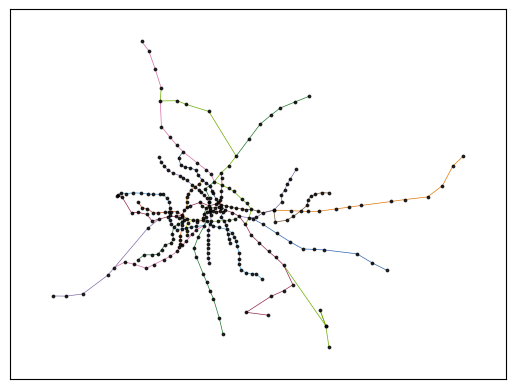

In [6]:
# plot nodes
pos = nx.get_node_attributes(G, "pos")
nx.draw_networkx_nodes(G, pos, node_size=3, node_color="black", alpha=0.8)

# plot edges and associated colours
edgeCols = list(nx.get_edge_attributes(G, "color").values())
nx.draw_networkx_edges(G, pos, edge_color=edgeCols, width=0.5, arrows=False)

## Plot Berlin network against a map


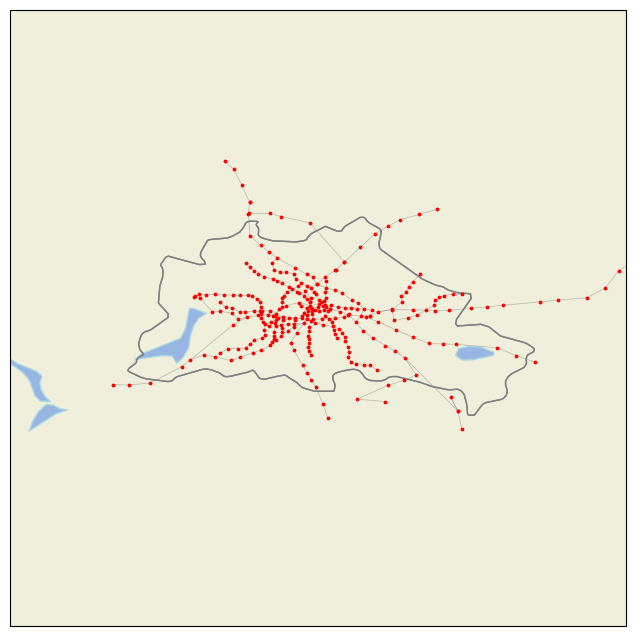

In [7]:
#https://cartopy.readthedocs.io/latest/matplotlib/feature_interface.html
mapProjection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1, projection=mapProjection)
ax.set_extent([12.9, 13.9, 52.0, 53.0], crs=ccrs.PlateCarree())

# plot geographical features
ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
ax.add_feature(cfeature.BORDERS, edgecolor="grey")
ax.add_feature(cfeature.LAKES, edgecolor="lightblue")
ax.add_feature(cfeature.OCEAN, edgecolor="lightblue")
ax.add_feature(cfeature.LAND, edgecolor="lightgreen")
ax.add_feature(cfeature.RIVERS, edgecolor="lightblue")
ax.add_feature(cfeature.STATES, edgecolor="grey")

# plot stations
ax.scatter(x=stations.longitude, y=stations.latitude, color="red", s=3, alpha=1, zorder=3,transform=ccrs.PlateCarree())

# plot connections
for u, v in G.edges():
    lon1, lat1 = pos[u]
    lon2, lat2 = pos[v]

    ax.plot([lon1, lon2], [lat1, lat2], color="grey", linewidth=0.5, alpha=0.5, transform=ccrs.Geodetic(), zorder=2)

Let's now show each line separately.

## Berlin's transport history

Now we have plotted all Berlin's train lines, let's investiagte Berlin's history. The first part of Berlin's underground network was opened in 1902 and the transport network stayed open, even after the city was split between two countries.

We'll start by looking when each station was built from the columns (constructionDate, closingDate). For stations that are still open, closing date is listed as NaN.

We'll use tkinter to create slider showing Berlin U-Bahn lines throughout time, and add national borders when necessary.